## Trigram Language Model - Road to ChatGPT series (1)

**Status:** Public Distribution <br>

**Author:** Jaume Manero<br>
**Date created:** 2023/04/20<br>
**Last modified:** <br>
**Description:** This notebook generates a trigram language model using El Quijote <br>
**Pointers/References** <br>
www.github.com/nltk/nltk/blob/develop/nltk/lm/__init__.py  <br>
www.analyticsvidhya.com/blog/2021/07/nltk-a-beginners-hands-on-guide-to-natural-language-processing/


In [1]:
import pandas as pd
import nltk
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends,padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
from nltk.lm import MLE

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/manero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# N-grams Language Models (N-grams LM)

Nowadays, everything seems to be going neural... 

Traditionally, we can use n-grams to generate language models to predict which word comes next given a history of words. 

We'll use the `lm` module in `nltk` to get a sense of how non-neural language modelling is done.

(**Source:** The content in this notebook is largely based on [language model tutorial in NLTK documentation by Ilia Kurenkov](https://github.com/nltk/nltk/blob/develop/nltk/lm/__init__.py))

If we want to train a bigram model, we need to turn this text into bigrams. Here's what the first sentence of our text would look like if we use the `ngrams` function from NLTK for this.

In [2]:
bookname = 'elquijote'
bookname = 'Cien años de soledad'
# opening the file in read mode
# my_file = open("./books/Cien anos de soledad - Gabriel Garcia Marquez.txt", "r", encoding="utf-8-sig")
my_file = open("./books/elquijote.txt", "r", encoding="utf-8-sig")
# reading the file
book = my_file.read()

In [3]:
# eliminar fin de frase, signos puntuacion
book = book.replace('\n', ' ')
book = book.replace("\'" ,'  ')
book = book.replace('.'  , ' ')
book = book.replace('!', ' ')
book = book.replace('?', ' ')
book = book.replace('—', ' ')

book = book.replace(':', ' ')
book = book.replace('_', ' ')
book = book.replace('¿', ' ')
book = book.replace('-', ' ')
book = book.replace(';', ' ')
book = book.replace(',', ' ')
book = book.replace('¡', ' ')

In [4]:
tokenized_book = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(book)]
print('El quijote tiene', len(tokenized_book[0]), 'palabras totales')
word_count = Counter(tokenized_book[0])
print('El quijote tiene', len(word_count), 'palabras distintas')
word_count_total = sum(y for x, y in word_count.items())
print('El quijote tiene', word_count_total,'palabras totales')

El quijote tiene 384279 palabras totales
El quijote tiene 22957 palabras distintas
El quijote tiene 384279 palabras totales


In [5]:
bigrams_book = list(bigrams(tokenized_book[0]))
trigrams_book = list(ngrams(tokenized_book[0], n=3))

print(bookname, 'Tiene ', len(bigrams_book), 'bigrams')
print(bookname, 'Tiene ', len(trigrams_book), 'trigrams')
bigrams_book[0:10]

Cien años de soledad Tiene  384278 bigrams
Cien años de soledad Tiene  384277 trigrams


[('el', 'ingenioso'),
 ('ingenioso', 'hidalgo'),
 ('hidalgo', 'don'),
 ('don', 'quijote'),
 ('quijote', 'de'),
 ('de', 'la'),
 ('la', 'mancha'),
 ('mancha', 'por'),
 ('por', 'miguel'),
 ('miguel', 'de')]

In [6]:
# Calculating frequencies
frequence_tri = nltk.FreqDist(trigrams_book)
frequence_bi = nltk.FreqDist(bigrams_book)
# sorting result


In [7]:
bigrams_df = pd.DataFrame (frequence_bi.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
trigrams_df = pd.DataFrame (frequence_tri.items(),columns=['tri','frequency']).sort_values(by='frequency',ascending=False)

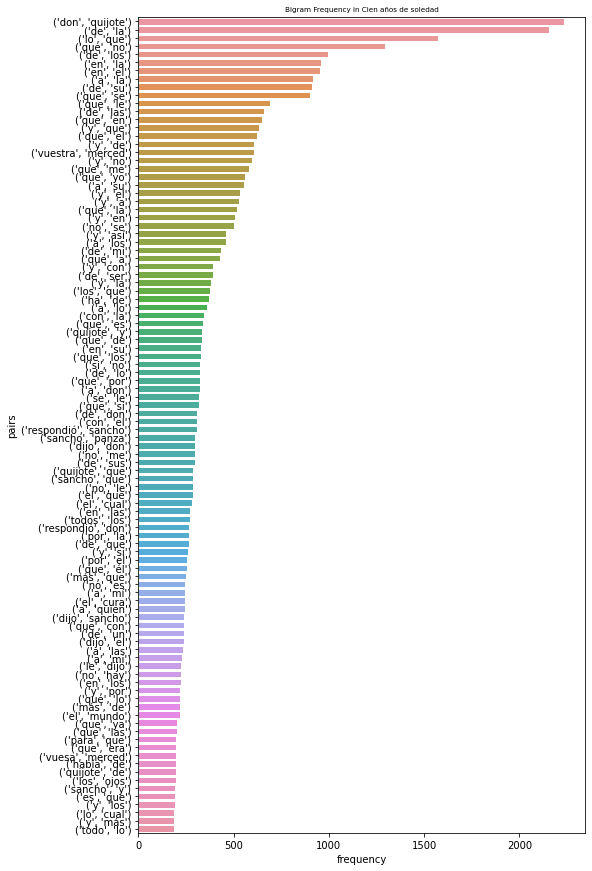

In [8]:
# create subplot of the different data frames
fig, axes = plt.subplots(1,1,figsize=(8,15))
sns.set(font_scale = 0.6)
axes.set_title('Bigram Frequency in '+bookname)
fig1 = sns.barplot(ax=axes,x='frequency',y='pairs',data=bigrams_df.head(100))
plt.show()

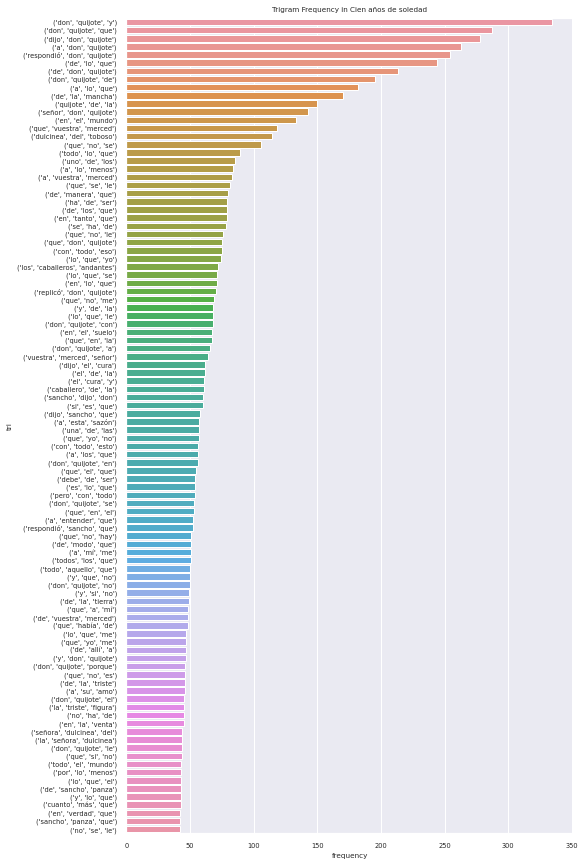

In [9]:
# create subplot trigrams
fig, axes = plt.subplots(1,1,figsize=(8,15))
sns.set(font_scale = 0.6)
axes.set_title('Trigram Frequency in '+bookname)
fig2 = sns.barplot(ax=axes,x='frequency',y='tri',data=trigrams_df.head(100))
plt.show()

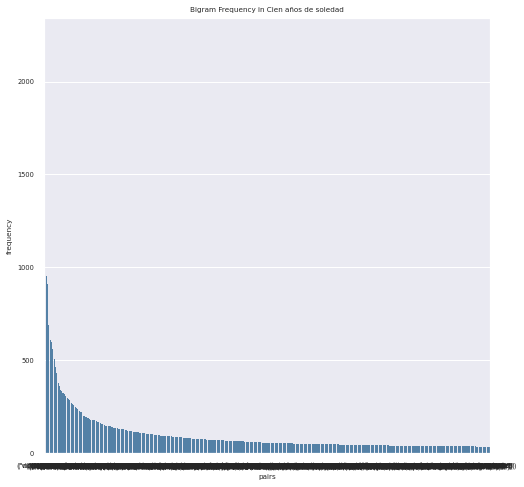

In [10]:
# See the long tail in bigram
fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale = 0.6)
axes.set_title('Bigram Frequency in '+bookname)
sns.set_context(rc = {'patch.linewidth': 0.0})
fig1 = sns.barplot(ax=axes,x='pairs',y='frequency',data=bigrams_df.head(1000), orient='v',
                  color = 'steelblue')
plt.show()

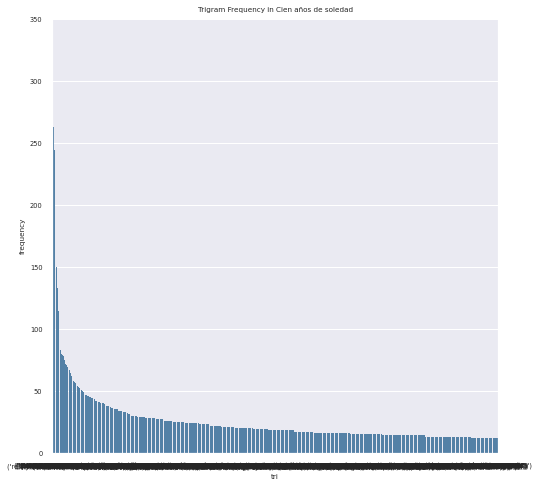

In [11]:
# See the long tail in bigram
fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale = 0.6)
axes.set_title('Trigram Frequency in '+bookname)
sns.set_context(rc = {'patch.linewidth': 0.0})
fig1 = sns.barplot(ax=axes,x='tri',y='frequency',data=trigrams_df.head(1000), orient='v',
                  color = 'steelblue')
plt.show()

In [12]:
# Construimos un modelo con trigrams
train_data, padded_sents = padded_everygram_pipeline(3, tokenized_book)

model_3 = MLE(3)
model_3.fit(train_data, padded_sents)
print(model_3.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 22960 items>


In [13]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [14]:
# Let's generate some text

In [15]:
generate_sent(model_3, 20, random_seed=7)

'en el más buen caballero don quijote pecador de mí al rucio rompió por ellos le preguntó si se le'

In [16]:
generate_sent(model_3, 50, random_seed=42)

'pegujares y dejaos de pretender ínsulas ni ciudades de grecia esto pues como digo no tuve dineros víame a pique está de mala cara y apenas habían sentado el pie sobre que yo viese a solas y procuro callarlo y encubrirlo de mis deseos con estas cosas mejor será dejarlas'

In [17]:
generate_sent(model_3, 100, random_seed=83)

'lo que de las armas que con gran quietud y los dieces asimismo como huevos medianos de avestruz el continente el paso de su carrera y allí no ve a nadie de su palafrén siguiéndole el bien deseado cuanto la supo formar el barbero que lo tiene y de haber con sancho panza así es verdad lo que le decía yo no la mandase quitar su antifaz ni la mañana en aquel lugar tan apartado del trato que pide un buen espacio mirando al del tener se atenía y el amo yo haré que firme otro por estrella de la'

In [18]:
# y con 4-grams?
train_data, padded_sents = padded_everygram_pipeline(4, tokenized_book)

model_4 = MLE(4)
model_4.fit(train_data, padded_sents)
print(model_4.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 22960 items>


In [19]:
generate_sent(model_4, 100, random_seed=7)

'en el más desalmado pecho del mundo por un autor moderno el mismo soy respondió el ya desnarigado escudero tomé cecial compadre y vecino de sancho panza su buen escudero sancho panza que aún dormía y allí se estuvo hasta casi que anochecía y aquella hora vio que venía un hombre a pie caminando apriesa y dando varazos a un macho que venía cargado de lanzas y de alabardas cuando llegó a mis oídos y en lugar de alegrar el oído aunque al mesmo instante alegraron también el oído el son de una trompeta tan triste que les hizo imaginar'

In [20]:
# con bigrams
train_data, padded_sents = padded_everygram_pipeline(2, tokenized_book)

model_2 = MLE(2)
model_2.fit(train_data, padded_sents)
print(model_2.vocab)
generate_sent(model_2, 50, random_seed=72)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 22960 items>


'atengo porque él hizo mejor lo que por los vestidos que guiada por mis oídos de sobrar escuderos que cide hamete a llorar la fortuna en tan leída y hubo bien vimos y los ciriales esperaban en buena gente en tales como aquél es artificio suelen obrar y traerle a'

In [21]:
# con unigrams
train_data, padded_sents = padded_everygram_pipeline(1, tokenized_book)

model_1 = MLE(1)
model_1.fit(train_data, padded_sents)
print(model_1.vocab)
generate_sent(model_1, 50, random_seed=12)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 22958 items>


'le por por conteniéndose a flamencas dulcinea ser que nos morisco por cordura la curarme uno antes si aun punto enviarle hagamos su a aposento ventura los buen yerba y centinela huelga con en oído cuántos que ama de señor habían hizo no le gigante acordamos que y y por'

In [22]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.5.0
nltk                3.8.1
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-40-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-04-25 22:47


In [23]:
#EOF